In [1]:
import os
import sys
sys.path.append('../chromdyn')
from Topology import TopologyGenerator
from ChromatinDynamics import ChromatinDynamics
from Reporters import save_pdb

from HiCManager import HiCManager
hicman = HiCManager()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Cupy is available


In [2]:
generator = TopologyGenerator()
n_beads_per_chain = 100
chain_num = 1

N = n_beads_per_chain * chain_num # total number of beads
# generate chain list
chain_list = [n_beads_per_chain for i in range(chain_num)]
type_list = []
block_length = 20
for i in range(N):
    if (i // block_length) % 2 == 0:
        type_list.append("A")
    else:
        type_list.append("B")

generator.gen_top(chain_list, type_list)

mass = 0.001
friction = 1.0

In [3]:
# Choose available platform
sim = ChromatinDynamics(generator.topology, name = 'testPBC', platform_name = "CUDA", output_dir = "output", console_stream = True, mass = mass)

#Add forces
kb = 30.0
lb = 1.0
sim.force_field_manager.add_harmonic_bonds(r0 = lb, k = kb,)# this function will automatically add bonds according to the topology file

kbound = 30.0
# note the formula of self avoidance here is different from OpenMiChroM
sim.force_field_manager.add_self_avoidance(Ecut = 5.0, k = 20.0, r = 1.0) #r = sigma = 2*radius

2025-12-04 13:04:37,925 | INFO | ChromatinDynamics | ************************************************************
2025-12-04 13:04:37,926 | INFO | ChromatinDynamics |                      Chromatin Dynamics                     
2025-12-04 13:04:37,927 | INFO | ChromatinDynamics | ************************************************************
2025-12-04 13:04:37,927 | INFO | ChromatinDynamics | System initialized with 100 particles. Output directory: output
2025-12-04 13:04:37,928 | INFO | Platforms | Platform 'CUDA' is available and selected.
2025-12-04 13:04:37,928 | INFO | ChromatinDynamics | force_field_manager initialized. Use this to add forces before running setup.
2025-12-04 13:04:37,932 | INFO | Forcefield | Adding 99 harmonic bonds with r0=1.0, k=30.0, group=0
2025-12-04 13:04:37,932 | INFO | Forcefield | HarmonicBonds force successfully added to system.
2025-12-04 13:04:37,934 | INFO | Forcefield | --------------------------------------------------
2025-12-04 13:04:37,935 | INF

In [4]:
block_size_prod = 200 # 0.1 tau_sim
T = 0.0
sim.simulation_setup(
    init_struct='randomwalk',
    integrator='active-langevin',
    temperature=T,
    timestep=0.0005,
    friction=friction,
    save_pos=True,
    save_energy=True,
    energy_report_interval=5_000,
    pos_report_interval=block_size_prod,    
    PBC = True,
    box_vectors = (
        (10.0, 0.0, 0.0),
        (0.0, 10.0, 0.0),
        (0.0, 0.0, 10.0)
    )   
)

print("Simulating under temperature:", T)

2025-12-04 13:04:38,603 | INFO | Forcefield | Updated nonbonded method for SelfAvoidance to Periodic.
2025-12-04 13:04:38,604 | INFO | Integrators | Creating integrator ...
2025-12-04 13:04:38,605 | INFO | Integrators | Active LangevinIntegrator: temperature=0.0 | friction=1.0 | timestep=0.0005
2025-12-04 13:04:38,605 | INFO | Integrators | Initialized active parameters: F=0.0 and t_corr=1.0.
2025-12-04 13:04:38,606 | INFO | Integrators | These parameters are per dof variables and can be set any time using .set_active_params(F_seq, tau_seq)


Updated nonbonded method for SelfAvoidance to Periodic.


2025-12-04 13:04:38,832 | INFO | ChromatinDynamics | Setting up simulation context...
2025-12-04 13:04:38,835 | INFO | ChromatinDynamics | Minimizing energy to resolve PBC overlaps...
2025-12-04 13:04:39,047 | INFO | ChromatinDynamics | Random walk created. Position shape: (100, 3)
2025-12-04 13:04:39,048 | INFO | ChromatinDynamics | Simulation context initialized.
2025-12-04 13:04:39,048 | INFO | ChromatinDynamics | ------------------------------------------------------------------------------------------------------------------------
2025-12-04 13:04:39,049 | INFO | ChromatinDynamics | Index  Force Class                    Force Name           Group    Particles    Bonds        Exclusions   P.E./Particle       
2025-12-04 13:04:39,049 | INFO | ChromatinDynamics | ------------------------------------------------------------------------------------------------------------------------
2025-12-04 13:04:39,050 | INFO | ChromatinDynamics | 0      HarmonicBondForce              HarmonicBond

Simulating under temperature: 0.0


In [5]:
F = 1.0
tau = 1.0

type_array = np.array(type_list)
F_seq = np.zeros(N)
F_seq = np.array((type_array == 'A').astype(int))*  F
print(F_seq)
tau_seq=[tau]*sim.num_particles

sim.set_activity(F_seq=F_seq, tau_seq=tau_seq)

2025-12-04 13:04:44,117 | INFO | ChromatinDynamics | Added active force and correlation times for 100 particles.


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [6]:
simulation = sim.simulation
system = simulation.system
context = simulation.context
print(f"System uses PBC? {system.usesPeriodicBoundaryConditions()}")


System uses PBC? True


In [7]:
# step 3: relaxasion simulation
relaxation_steps = 100 * block_size_prod # 5000 tau_sim
sim.run(relaxation_steps, report=False)

reporter = sim.reporters['stability']
print(reporter.kinetic_threshold) # this should show 5.0
reporter.kinetic_threshold = 80.0
print(reporter.kinetic_threshold) # this should show 80.0

2025-12-04 13:04:45,709 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-12-04 13:04:45,709 | INFO | ChromatinDynamics | Running simulation for 20000 steps...
2025-12-04 13:04:45,709 | INFO | ChromatinDynamics | Paused reporter: position
2025-12-04 13:04:45,710 | INFO | ChromatinDynamics | Paused reporter: energy
2025-12-04 13:04:48,170 | INFO | ChromatinDynamics | Completed 20000 steps in 2.46s (8133 steps/s)
2025-12-04 13:04:48,172 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-12-04 13:04:48,174 | INFO | ChromatinDynamics | Resumed reporter: position
2025-12-04 13:04:48,174 | INFO | ChromatinDynamics | Resumed reporter: energy


5.0
80.0


In [8]:
simulation = sim.simulation
system = simulation.system
context = simulation.context
print(f"System uses PBC? {system.usesPeriodicBoundaryConditions()}")

System uses PBC? True


In [9]:

n_blocks_prod = 1000
running_steps = n_blocks_prod * block_size_prod
v_history = []

for _ in range(n_blocks_prod):
    sim.run(block_size_prod, report=True)
    state = sim.simulation.context.getState(getVelocities=True)
    current_velocities = state.getVelocities(asNumpy=True)
    v_history.append(current_velocities)

# save velocity history
v_history = np.array(v_history)
np.save(os.path.join('output', f"velocity_history.npy"), v_history)
del v_history

# verify potential forces are added
sim.print_force_info()


2025-12-04 13:05:11,056 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-12-04 13:05:11,057 | INFO | ChromatinDynamics | Running simulation for 200 steps...
2025-12-04 13:05:11,106 | INFO | ChromatinDynamics | Completed 200 steps in 0.05s (4193 steps/s)
2025-12-04 13:05:11,106 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-12-04 13:05:11,107 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-12-04 13:05:11,108 | INFO | ChromatinDynamics | Running simulation for 200 steps...
2025-12-04 13:05:11,150 | INFO | ChromatinDynamics | Completed 200 steps in 0.04s (4727 steps/s)
2025-12-04 13:05:11,151 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-12-04 13:05:11,152 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-12-04 13:05:11,152 | INFO | ChromatinDynamics | Runni

In [ ]:
traj_file=sim.reporters.get('position').filename
#traj_file='output/testPBC_positions.cndb'
velocity_file = os.path.join('output', f"velocity_history.npy")


In [12]:
# tools.py rely on OpenMiChroM.CndbTools, one may not choose to use it
r'''from tools import ndb2cndb, load, xyz
from OpenMiChroM.CndbTools import cndbTools
cndb_tool = cndbTools()
traj = load(cndb_tool, filename = traj_file)'''

'from tools import ndb2cndb, load, xyz\nfrom OpenMiChroM.CndbTools import cndbTools\ncndb_tool = cndbTools()\ntraj = load(cndb_tool, filename = traj_file)'

In [7]:
from Cndbtools import ChromatinTrajectory
# in this new class, we can load the file and extract the trajectory with .load(), .xyz(), 
# or one can import load_trajectory(),get_xyz() function, they're the same, with self a ChromatinTrajectory object.
traj = ChromatinTrajectory(traj_file)
xyz = traj.xyz(frames=[0, None, 1], beadSelection=None)


Loaded output/testPBC_positions.cndb: 1000 frames, 100 beads.
Topology: <TopologyData: 1 chains, 100 beads, 99 bonds>
Box vectors loaded. Shape: (1000, 3, 3)


In [13]:
# calculate Rg by types
from Cndbtools import compute_RG_type
rg_result = compute_RG_type(traj)
rg_result.keys()

dict_keys(['general', 'A', 'B'])

In [15]:
#print(xyz)

In [16]:
# check if the box vectors are correctly saved, should be (Nframes, 3, 3)
np.shape(traj.box_vectors)

(1000, 3, 3)

In [17]:
traj.box_vectors

array([[[10.,  0.,  0.],
        [ 0., 10.,  0.],
        [ 0.,  0., 10.]],

       [[10.,  0.,  0.],
        [ 0., 10.,  0.],
        [ 0.,  0., 10.]],

       [[10.,  0.,  0.],
        [ 0., 10.,  0.],
        [ 0.,  0., 10.]],

       ...,

       [[10.,  0.,  0.],
        [ 0., 10.,  0.],
        [ 0.,  0., 10.]],

       [[10.,  0.,  0.],
        [ 0., 10.,  0.],
        [ 0.,  0., 10.]],

       [[10.,  0.,  0.],
        [ 0., 10.,  0.],
        [ 0.,  0., 10.]]], shape=(1000, 3, 3))

In [ ]:
# calculate PBC-HiC(image contact included)
hic = hicman.gen_pbc_hic_from_cndb(traj_file = traj_file, mu = 3.22, rc = 1.78,p = None, platform = 'CUDA', batch_size = 100)

2025-12-03 15:35:41,644 | INFO | HiCManager | Computing PBC Hi-C with mu=3.22, rc=1.78, p=None...
2025-12-03 15:35:41,777 | INFO | HiCManager | Trajectory shape: (1000, 100, 3), Box data shape: (1000, 3, 3)
2025-12-03 15:35:41,792 | INFO | HiCManager | Computing PBC HiC on GPU...


Loaded output/testPBC_positions.cndb: 1000 frames, 100 beads.
Topology: <TopologyData: 1 chains, 100 beads, 99 bonds>
Box vectors loaded. Shape: (1000, 3, 3)


2025-12-03 15:35:42,793 | INFO | HiCManager | Generated PBC HiC matrix of shape: (100, 100)


In [12]:
traj.ChromSeq


['A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A']

In [13]:
traj.topology.bonds

[[0, 1],
 [1, 2],
 [2, 3],
 [3, 4],
 [4, 5],
 [5, 6],
 [6, 7],
 [7, 8],
 [8, 9],
 [9, 10],
 [10, 11],
 [11, 12],
 [12, 13],
 [13, 14],
 [14, 15],
 [15, 16],
 [16, 17],
 [17, 18],
 [18, 19],
 [19, 20],
 [20, 21],
 [21, 22],
 [22, 23],
 [23, 24],
 [24, 25],
 [25, 26],
 [26, 27],
 [27, 28],
 [28, 29],
 [29, 30],
 [30, 31],
 [31, 32],
 [32, 33],
 [33, 34],
 [34, 35],
 [35, 36],
 [36, 37],
 [37, 38],
 [38, 39],
 [39, 40],
 [40, 41],
 [41, 42],
 [42, 43],
 [43, 44],
 [44, 45],
 [45, 46],
 [46, 47],
 [47, 48],
 [48, 49],
 [49, 50],
 [50, 51],
 [51, 52],
 [52, 53],
 [53, 54],
 [54, 55],
 [55, 56],
 [56, 57],
 [57, 58],
 [58, 59],
 [59, 60],
 [60, 61],
 [61, 62],
 [62, 63],
 [63, 64],
 [64, 65],
 [65, 66],
 [66, 67],
 [67, 68],
 [68, 69],
 [69, 70],
 [70, 71],
 [71, 72],
 [72, 73],
 [73, 74],
 [74, 75],
 [75, 76],
 [76, 77],
 [77, 78],
 [78, 79],
 [79, 80],
 [80, 81],
 [81, 82],
 [82, 83],
 [83, 84],
 [84, 85],
 [85, 86],
 [86, 87],
 [87, 88],
 [88, 89],
 [89, 90],
 [90, 91],
 [91, 92],
 [92, 9

In [14]:
traj.topology.chains

[{'index': 0,
  'id': 'C1',
  'residues': [{'index': 0,
    'name': 'L1',
    'id': '1',
    'atoms': [{'index': 0, 'name': 'C1-L1-1', 'type': 'A'}]},
   {'index': 1,
    'name': 'L2',
    'id': '2',
    'atoms': [{'index': 1, 'name': 'C1-L2-1', 'type': 'A'}]},
   {'index': 2,
    'name': 'L3',
    'id': '3',
    'atoms': [{'index': 2, 'name': 'C1-L3-1', 'type': 'A'}]},
   {'index': 3,
    'name': 'L4',
    'id': '4',
    'atoms': [{'index': 3, 'name': 'C1-L4-1', 'type': 'A'}]},
   {'index': 4,
    'name': 'L5',
    'id': '5',
    'atoms': [{'index': 4, 'name': 'C1-L5-1', 'type': 'A'}]},
   {'index': 5,
    'name': 'L6',
    'id': '6',
    'atoms': [{'index': 5, 'name': 'C1-L6-1', 'type': 'A'}]},
   {'index': 6,
    'name': 'L7',
    'id': '7',
    'atoms': [{'index': 6, 'name': 'C1-L7-1', 'type': 'A'}]},
   {'index': 7,
    'name': 'L8',
    'id': '8',
    'atoms': [{'index': 7, 'name': 'C1-L8-1', 'type': 'A'}]},
   {'index': 8,
    'name': 'L9',
    'id': '9',
    'atoms': [{'index':

In [15]:
traj.topology.n_chains

1

In [16]:
traj.Nbeads

100

In [17]:
traj.topology.chain_info

[('C1', 100)]

In [18]:
import inspect

# print the source code of traj.xyz
print(inspect.getsource(traj.xyz))
print(traj.xyz.__code__.co_filename)

    def xyz(self, frames=[0, None, 1], beadSelection=None, XYZ=[0, 1, 2]):
        """call external get_xyz function"""
        return get_xyz(self, frames, beadSelection, XYZ)

c:\Users\Leren\Documents\GitHub\chromdyn\notebooks\../chromdyn\Cndbtools.py


PBC is enabled, automatically recentering.
Recentering coordinates...
Using types from trajectory: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']


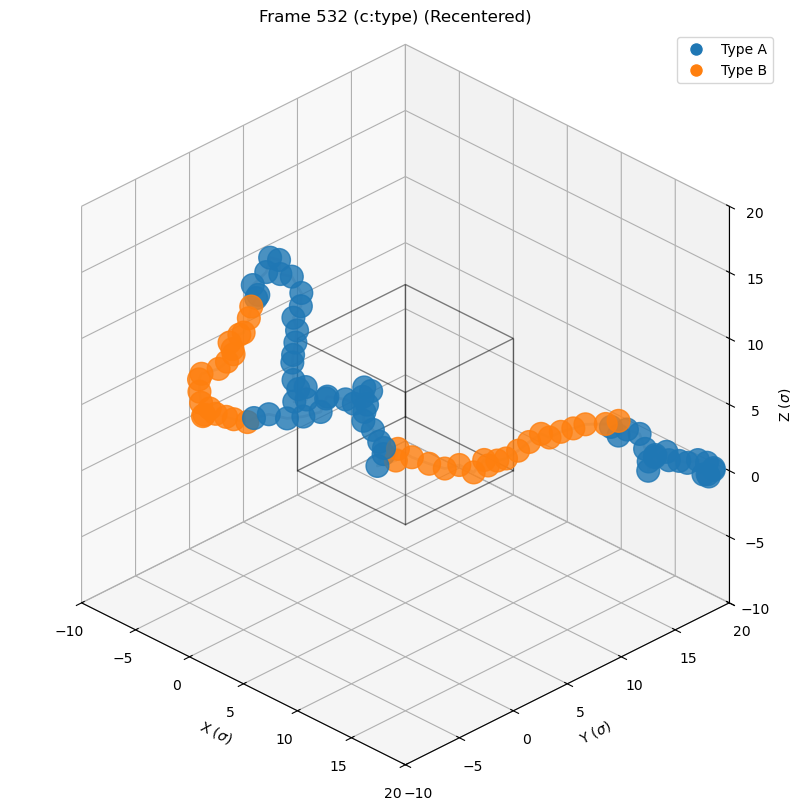

In [12]:
from Cndbtools import visualize, visualize_animation
# these 2 visualization function are for the new format of cndb files with pbc mode on
pbc_box_side_length = 10
visualize(
     traj = traj,
     select_frame=532,
     axis_limits=(-10, pbc_box_side_length + 10, -10, pbc_box_side_length + 10, -10, pbc_box_side_length + 10), # Optional
     colors=None, # Optional
     isring=False,
     r=0.5,
     PBC=True,
     color_mode='type'
 )



Plotting 27 lattice copies...


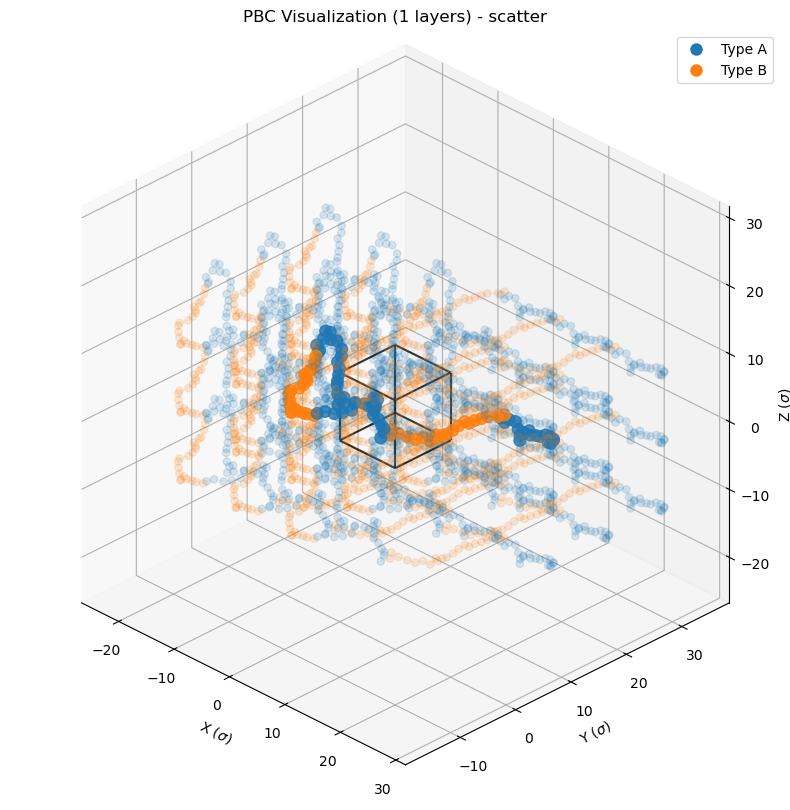

In [13]:
from Cndbtools import visualize_pbc_images
visualize_pbc_images(
    traj = traj,
    select_frame = 532,
    n_layers = 1, # 3*3*3 grid
    image_alpha = 0.15,
    image_style = 'scatter',
    r = 0.5,
    color_mode = 'type'
)

In [ ]:
plt.rcParams['animation.html'] = 'jshtml'
pbc_box_side_length = 10
visualize_animation(
     traj = traj,
     #box_a=pbc_box_side_length,
     start_frame = 0,
     end_frame = 300,
     axis_limits=(-10, pbc_box_side_length + 10, -10, pbc_box_side_length + 10, -10, pbc_box_side_length + 10), # Optional
     colors=None, # Optional
     isring=False,
     r=0.5,
     outputName = 'output/animation_pbc.mp4',
     PBC=True
 )

Loading frames 0 to 300...
Generating animation...
Saved to output/animation_pbc.gif


In [21]:
# velocity correlation checking
velocity = np.load(velocity_file)   
#velocity

In [22]:
# There're two functions that calculate time and spatial coorelation of velocity inside Cndbtools.py, using GPU acceleration
from Cndbtools import calculate_vacf_gpu, calculate_spatial_vel_corr_gpu

bead_types = np.array(traj.ChromSeq)
v_correlation = calculate_vacf_gpu(
    velocity,
    bead_types,
    sampling_step=1
)

v_spatial_correlation = calculate_spatial_vel_corr_gpu(
    coords = xyz,
    velocities = velocity,
    bead_types = bead_types,
    sampling_step=1,
    dist_range=10.0,
    num_bins=50,
)

dict_keys(['general', np.str_('A')])


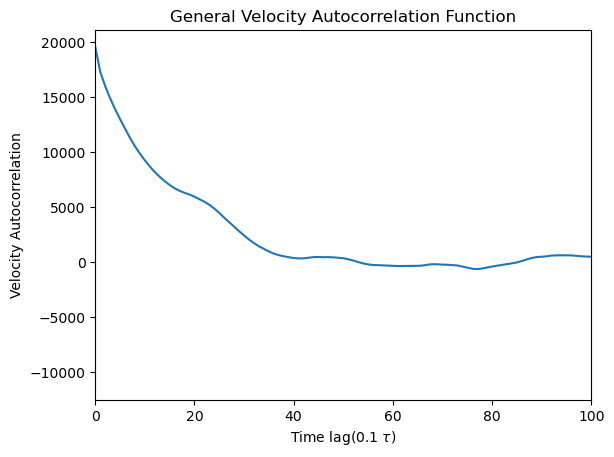

In [23]:
# Each output is a dictionary with the correlation function for general and each bead type
# verify format if v_correlation
print(v_correlation.keys())
# plot the correlation function (time series)
v_plot = v_correlation['general']
import matplotlib.pyplot as plt

plt.figure()
plt.plot(v_plot)
plt.xlabel(r'Time lag(0.1 $\tau$)')
plt.ylabel('Velocity Autocorrelation')
plt.xlim(0,100)
plt.title('General Velocity Autocorrelation Function')
plt.show()



dict_keys(['general', 'A-A', 'bin_centers'])


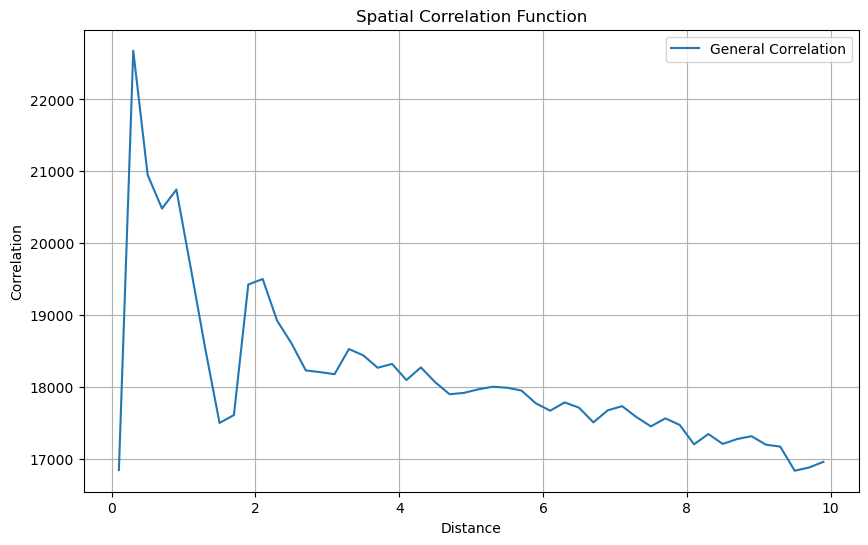

In [24]:
# The output is a dictionary with the correlation function for general and each bead type
# verify format if v_correlation
print(v_spatial_correlation.keys())
# plot spatial correlation, x axis  = v_spatial_correlation['bin_centers'], y axis = ['general']
plt.figure(figsize=(10, 6))
plt.plot(v_spatial_correlation['bin_centers'], v_spatial_correlation['general'], label='General Correlation')
plt.xlabel('Distance')
plt.ylabel('Correlation')
plt.title('Spatial Correlation Function')
plt.legend()
plt.grid(True)
plt.show()
